# 🎬 Face Swapping sur Vidéos MP4

Ce notebook implémente un système de **face swapping intelligent sur vidéos MP4** avec deux modes de fonctionnement :

## 🎯 Modes de Fonctionnement

### Mode 1 : Un seul visage détecté
- **Swap avec une image source** du dossier `assets/`
- Le visage détecté est remplacé par le visage de l'image source
- Idéal pour anonymiser ou remplacer un visage dans une vidéo

### Mode 2 : Deux visages détectés
- **Swap automatique entre les deux visages**
- Le visage A prend la place du visage B et vice versa
- Parfait pour des effets amusants ou des vidéos avec deux personnes

## ✨ Fonctionnalités

- ✅ **Détection automatique** du nombre de visages
- ✅ **Logique intelligente** : swap adaptatif selon le nombre de visages
- ✅ **Inclusion du front** dans le remplacement
- ✅ **Préservation de la bouche** ouverte (intérieur conservé)
- ✅ **Traitement frame par frame** avec suivi de progression
- ✅ **Export MP4** avec codec H.264
- ✅ **Prévisualisation** des frames traitées
- ✅ **Audio préservé** (copié de la vidéo originale)

## 📋 Workflow

1. **Chargement** de la vidéo MP4 source
2. **Détection** des visages dans chaque frame
3. **Application** de la logique de swap selon le nombre de visages
4. **Export** de la vidéo traitée avec audio
5. **Visualisation** des résultats

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.spatial import Delaunay
from tqdm.notebook import tqdm
import time
from IPython.display import Video, display, HTML

# Configuration matplotlib
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 8)

print("✓ Bibliothèques importées!")
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")

✓ Bibliothèques importées!
OpenCV version: 4.12.0
NumPy version: 2.2.6


In [2]:
import urllib.request

landmark_model_path = "lbfmodel.yaml"

if not os.path.exists(landmark_model_path):
    print("⏬ Téléchargement du modèle de landmarks...")
    url = "https://raw.githubusercontent.com/kurnianggoro/GSOC2017/master/data/lbfmodel.yaml"
    
    try:
        urllib.request.urlretrieve(url, landmark_model_path)
        print("✓ Modèle téléchargé avec succès!")
    except Exception as e:
        print(f"❌ Erreur de téléchargement: {e}")
else:
    print("✓ Modèle déjà présent!")

✓ Modèle déjà présent!


In [3]:
class VideoFaceSwapper:
    """
    Classe pour le face swapping sur vidéos avec logique intelligente.
    """
    
    def __init__(self, landmark_model_path="lbfmodel.yaml"):
        """Initialisation du système de face swapping vidéo."""
        # Détecteur de visages (Haar Cascade)
        self.face_cascade = cv2.CascadeClassifier(
            cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
        )
        
        # Détecteur de landmarks (LBF)
        self.facemark = None
        try:
            self.facemark = cv2.face.createFacemarkLBF()
            if os.path.exists(landmark_model_path):
                self.facemark.loadModel(landmark_model_path)
                print("✓ Détecteur de landmarks chargé")
            else:
                print("⚠ Modèle de landmarks non trouvé")
        except Exception as e:
            print(f"⚠ Erreur lors du chargement du détecteur: {e}")
        
        print("✓ VideoFaceSwapper initialisé!")
    
    def detect_faces(self, frame):
        """Détecter les visages dans une frame."""
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = self.face_cascade.detectMultiScale(gray, 1.1, 5, minSize=(100, 100))
        return faces
    
    def get_landmarks(self, frame, face_rect):
        """Obtenir les landmarks pour un visage."""
        if self.facemark is None:
            return self._estimate_landmarks(face_rect)
        
        try:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            faces = np.array([face_rect], dtype=np.int32)
            success, landmarks = self.facemark.fit(gray, faces)
            
            if success and len(landmarks) > 0:
                return landmarks[0][0].astype(np.int32)
        except:
            pass
        
        return self._estimate_landmarks(face_rect)
    
    def _estimate_landmarks(self, face_rect):
        """Estimer les landmarks basiques à partir du rectangle du visage."""
        x, y, w, h = face_rect
        landmarks = []
        
        # Face outline (17 points)
        for i in range(17):
            ratio = i / 16.0
            lx = int(x + w * 0.1 + w * 0.8 * ratio)
            ly = int(y + h * (0.2 + 0.6 * abs(ratio - 0.5)))
            landmarks.append([lx, ly])
        
        # Eyebrows (10 points)
        for i in range(5):
            landmarks.append([int(x + w * (0.2 + i * 0.08)), int(y + h * 0.3)])
        for i in range(5):
            landmarks.append([int(x + w * (0.56 + i * 0.08)), int(y + h * 0.3)])
        
        # Nose (9 points)
        for i in range(9):
            landmarks.append([int(x + w * 0.5), int(y + h * (0.35 + i * 0.05))])
        
        # Eyes (12 points)
        eye_x, eye_y, eye_w = x + int(w * 0.3), y + int(h * 0.4), int(w * 0.15)
        for i in range(6):
            angle = i * np.pi / 3
            landmarks.append([int(eye_x + eye_w * np.cos(angle)), 
                            int(eye_y + eye_w * 0.5 * np.sin(angle))])
        
        eye_x = x + int(w * 0.7)
        for i in range(6):
            angle = i * np.pi / 3
            landmarks.append([int(eye_x + eye_w * np.cos(angle)), 
                            int(eye_y + eye_w * 0.5 * np.sin(angle))])
        
        # Mouth (20 points)
        mouth_x, mouth_y, mouth_w = x + int(w * 0.5), y + int(h * 0.75), int(w * 0.4)
        for i in range(12):
            angle = i * 2 * np.pi / 12
            landmarks.append([int(mouth_x + mouth_w * np.cos(angle)),
                            int(mouth_y + mouth_w * 0.3 * np.sin(angle))])
        for i in range(8):
            angle = i * 2 * np.pi / 8
            landmarks.append([int(mouth_x + mouth_w * 0.6 * np.cos(angle)),
                            int(mouth_y + mouth_w * 0.2 * np.sin(angle))])
        
        return np.array(landmarks, dtype=np.int32)
    
    def extend_landmarks_with_forehead(self, landmarks, image_shape):
        """Étendre les landmarks pour inclure le front."""
        landmarks = np.array(landmarks, dtype=np.float32)
        
        if len(landmarks) >= 27:
            left_eyebrow = landmarks[19]
            right_eyebrow = landmarks[24]
            nose_bridge = landmarks[27]
            left_face = landmarks[0]
            right_face = landmarks[16]
            
            eyebrow_avg_y = (left_eyebrow[1] + right_eyebrow[1]) / 2
            forehead_height = abs(nose_bridge[1] - eyebrow_avg_y) * 1.5
            
            forehead_points = [
                [left_face[0] + (landmarks[1][0] - left_face[0]) * 0.3, eyebrow_avg_y - forehead_height],
                [left_eyebrow[0], eyebrow_avg_y - forehead_height * 1.1],
                [(left_eyebrow[0] + right_eyebrow[0]) / 2, eyebrow_avg_y - forehead_height * 1.2],
                [right_eyebrow[0], eyebrow_avg_y - forehead_height * 1.1],
                [right_face[0] - (right_face[0] - landmarks[15][0]) * 0.3, eyebrow_avg_y - forehead_height]
            ]
            
            extended = np.vstack([landmarks, forehead_points])
            return extended.astype(np.int32)
        
        return landmarks.astype(np.int32)
    
    def is_mouth_open(self, landmarks, threshold=0.05):
        """Détecter si la bouche est ouverte."""
        if len(landmarks) < 68:
            return False, 0.0
        
        upper_lip_center = landmarks[62]
        lower_lip_center = landmarks[66]
        left_corner = landmarks[48]
        right_corner = landmarks[54]
        
        mouth_height = abs(lower_lip_center[1] - upper_lip_center[1])
        mouth_width = abs(right_corner[0] - left_corner[0])
        
        if mouth_width > 0:
            mouth_ratio = mouth_height / mouth_width
        else:
            mouth_ratio = 0
        
        return mouth_ratio > threshold, mouth_ratio
    
    def get_face_mask(self, image_shape, landmarks, exclude_inner_mouth=False):
        """Créer un masque pour le visage (avec front)."""
        extended_landmarks = self.extend_landmarks_with_forehead(landmarks, image_shape)
        
        mask = np.zeros(image_shape[:2], dtype=np.uint8)
        hull = cv2.convexHull(extended_landmarks)
        cv2.fillConvexPoly(mask, hull, 255)
        
        # Exclure l'intérieur de la bouche si nécessaire
        if exclude_inner_mouth and len(landmarks) >= 68:
            inner_mouth_points = landmarks[60:68].astype(np.int32)
            inner_mouth_mask = np.zeros(image_shape[:2], dtype=np.uint8)
            cv2.fillConvexPoly(inner_mouth_mask, inner_mouth_points, 255)
            kernel = np.ones((5, 5), np.uint8)
            inner_mouth_mask = cv2.dilate(inner_mouth_mask, kernel, iterations=1)
            mask = cv2.subtract(mask, inner_mouth_mask)
        
        mask = cv2.GaussianBlur(mask, (3, 3), 0)
        return mask
    
    def warp_triangle(self, img1, img2, t1, t2):
        """Warper un triangle de img1 vers img2."""
        r1 = cv2.boundingRect(np.float32([t1]))
        r2 = cv2.boundingRect(np.float32([t2]))
        
        t1_rect = []
        t2_rect = []
        
        for i in range(3):
            t1_rect.append(((t1[i][0] - r1[0]), (t1[i][1] - r1[1])))
            t2_rect.append(((t2[i][0] - r2[0]), (t2[i][1] - r2[1])))
        
        mask = np.zeros((r2[3], r2[2], 3), dtype=np.float32)
        cv2.fillConvexPoly(mask, np.int32(t2_rect), (1.0, 1.0, 1.0), 16, 0)
        
        img1_rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
        
        if img1_rect.size == 0 or r2[2] <= 0 or r2[3] <= 0:
            return
        
        warp_mat = cv2.getAffineTransform(np.float32(t1_rect), np.float32(t2_rect))
        img2_rect = cv2.warpAffine(img1_rect, warp_mat, (r2[2], r2[3]), None,
                                    flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
        
        img2_rect = img2_rect * mask
        
        img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = \
            img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ((1.0, 1.0, 1.0) - mask)
        
        img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = \
            img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2_rect
    
    def swap_faces(self, src_image, src_landmarks, dst_image, dst_landmarks):
        """Swapper deux visages."""
        try:
            src_img = np.float32(src_image)
            dst_img = np.float32(dst_image)
            result = dst_img.copy()
            
            # Vérifier bouche ouverte
            mouth_is_open, _ = self.is_mouth_open(dst_landmarks)
            
            # Étendre landmarks avec front
            dst_extended = self.extend_landmarks_with_forehead(dst_landmarks, dst_image.shape)
            src_extended = self.extend_landmarks_with_forehead(src_landmarks, src_image.shape)
            
            # Triangulation Delaunay
            tri = Delaunay(dst_extended)
            triangles = tri.simplices
            
            # Warper chaque triangle
            for triangle_indices in triangles:
                t1 = [src_extended[i] for i in triangle_indices]
                t2 = [dst_extended[i] for i in triangle_indices]
                self.warp_triangle(src_img, result, t1, t2)
            
            # Créer masque
            mask = self.get_face_mask(dst_image.shape, dst_landmarks, exclude_inner_mouth=mouth_is_open)
            
            # Seamless cloning
            r = cv2.boundingRect(cv2.convexHull(dst_extended))
            center = (r[0] + int(r[2] / 2), r[1] + int(r[3] / 2))
            
            result = np.uint8(result)
            output = cv2.seamlessClone(result, dst_image, mask, center, cv2.NORMAL_CLONE)
            
            return output
        except Exception as e:
            print(f"Erreur swap: {e}")
            return dst_image

print("✓ Classe VideoFaceSwapper définie!")

✓ Classe VideoFaceSwapper définie!


In [4]:
class MP4FaceSwapProcessor:
    """
    Processeur intelligent pour face swapping sur vidéos MP4.
    
    Logique:
    - 1 visage détecté → Swap avec image source du dossier assets/
    - 2 visages détectés → Swap entre les deux visages
    - 0 ou 3+ visages → Frame originale (pas de traitement)
    """
    
    def __init__(self, source_image_path=None):
        """
        Initialiser le processeur.
        
        Args:
            source_image_path: Chemin vers l'image source pour le mode 1 visage
        """
        self.swapper = VideoFaceSwapper()
        self.source_image = None
        self.source_face = None
        self.source_landmarks = None
        
        # Charger l'image source si fournie
        if source_image_path and os.path.exists(source_image_path):
            self._load_source_image(source_image_path)
        
        # Statistiques
        self.stats = {
            'total_frames': 0,
            'frames_with_0_faces': 0,
            'frames_with_1_face': 0,
            'frames_with_2_faces': 0,
            'frames_with_3plus_faces': 0,
            'swap_successes': 0,
            'swap_failures': 0
        }
    
    def _load_source_image(self, image_path):
        """Charger et préparer l'image source."""
        print(f"📁 Chargement de l'image source: {image_path}")
        
        self.source_image = cv2.imread(image_path)
        if self.source_image is None:
            print(f"❌ Impossible de charger l'image source")
            return False
        
        # Détecter le visage dans l'image source
        faces = self.swapper.detect_faces(self.source_image)
        if len(faces) == 0:
            print("❌ Aucun visage détecté dans l'image source")
            self.source_image = None
            return False
        
        # Utiliser le premier visage
        self.source_face = faces[0]
        self.source_landmarks = self.swapper.get_landmarks(self.source_image, self.source_face)
        
        if self.source_landmarks is None:
            print("❌ Impossible de détecter les landmarks dans l'image source")
            self.source_image = None
            return False
        
        print(f"✓ Image source chargée avec {len(self.source_landmarks)} landmarks")
        return True
    
    def process_frame(self, frame):
        """
        Traiter une frame selon la logique intelligente.
        
        Args:
            frame: Frame à traiter
            
        Returns:
            Frame traitée, nombre de visages détectés
        """
        self.stats['total_frames'] += 1
        
        # Détecter les visages
        faces = self.swapper.detect_faces(frame)
        num_faces = len(faces)
        
        # Statistiques
        if num_faces == 0:
            self.stats['frames_with_0_faces'] += 1
        elif num_faces == 1:
            self.stats['frames_with_1_face'] += 1
        elif num_faces == 2:
            self.stats['frames_with_2_faces'] += 1
        else:
            self.stats['frames_with_3plus_faces'] += 1
        
        # Logique de traitement
        if num_faces == 1:
            # Mode 1 : Swap avec image source
            return self._process_single_face(frame, faces[0]), num_faces
        
        elif num_faces == 2:
            # Mode 2 : Swap entre les deux visages
            return self._process_two_faces(frame, faces), num_faces
        
        else:
            # 0 ou 3+ visages : pas de traitement
            return frame, num_faces
    
    def _process_single_face(self, frame, face_rect):
        """Traiter une frame avec 1 seul visage (swap avec source)."""
        if self.source_image is None:
            # Pas d'image source, retourner la frame originale
            return frame
        
        try:
            # Obtenir les landmarks du visage cible
            target_landmarks = self.swapper.get_landmarks(frame, face_rect)
            
            if target_landmarks is None:
                self.stats['swap_failures'] += 1
                return frame
            
            # Swapper le visage source sur la cible
            result = self.swapper.swap_faces(
                self.source_image,
                self.source_landmarks,
                frame,
                target_landmarks
            )
            
            self.stats['swap_successes'] += 1
            return result
            
        except Exception as e:
            self.stats['swap_failures'] += 1
            return frame
    
    def _process_two_faces(self, frame, faces):
        """Traiter une frame avec 2 visages (swap entre eux)."""
        try:
            # Obtenir les landmarks des deux visages
            face1_rect, face2_rect = faces[0], faces[1]
            
            landmarks1 = self.swapper.get_landmarks(frame, face1_rect)
            landmarks2 = self.swapper.get_landmarks(frame, face2_rect)
            
            if landmarks1 is None or landmarks2 is None:
                self.stats['swap_failures'] += 1
                return frame
            
            # Créer une copie temporaire pour le premier swap
            temp_frame = frame.copy()
            
            # Swap visage 1 → position visage 2
            result = self.swapper.swap_faces(
                frame,
                landmarks1,
                temp_frame,
                landmarks2
            )
            
            # Swap visage 2 → position visage 1
            result = self.swapper.swap_faces(
                frame,
                landmarks2,
                result,
                landmarks1
            )
            
            self.stats['swap_successes'] += 1
            return result
            
        except Exception as e:
            self.stats['swap_failures'] += 1
            return frame
    
    def process_video(self, input_path, output_path, show_preview=True, preview_interval=30):
        """
        Traiter une vidéo MP4 complète.
        
        Args:
            input_path: Chemin de la vidéo d'entrée
            output_path: Chemin de la vidéo de sortie
            show_preview: Afficher des frames de prévisualisation
            preview_interval: Intervalle entre les previews (en frames)
        """
        print("="*60)
        print("🎬 DÉMARRAGE DU TRAITEMENT VIDÉO")
        print("="*60)
        
        # Ouvrir la vidéo
        cap = cv2.VideoCapture(input_path)
        if not cap.isOpened():
            print(f"❌ Impossible d'ouvrir la vidéo: {input_path}")
            return False
        
        # Propriétés de la vidéo
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        
        print(f"\n📊 Informations vidéo:")
        print(f"   Résolution: {width}x{height}")
        print(f"   FPS: {fps}")
        print(f"   Total frames: {total_frames}")
        print(f"   Durée: {total_frames/fps:.2f} secondes")
        
        # Préparer le writer
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
        
        if not out.isOpened():
            print(f"❌ Impossible de créer le fichier de sortie: {output_path}")
            cap.release()
            return False
        
        # Traitement frame par frame
        print(f"\n⚙️ Traitement en cours...")
        print(f"   Mode: {'1 visage → source | 2 visages → swap mutuel' if self.source_image is not None else '2 visages → swap mutuel uniquement'}")
        
        frame_count = 0
        start_time = time.time()
        preview_frames = []
        
        with tqdm(total=total_frames, desc="Traitement", unit="frame") as pbar:
            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                
                # Traiter la frame
                processed_frame, num_faces = self.process_frame(frame)
                
                # Écrire la frame traitée
                out.write(processed_frame)
                
                # Sauvegarder pour preview
                if show_preview and frame_count % preview_interval == 0:
                    preview_frames.append((frame_count, frame.copy(), processed_frame.copy(), num_faces))
                
                frame_count += 1
                pbar.update(1)
                
                # Mise à jour de la description avec stats
                if frame_count % 10 == 0:
                    pbar.set_postfix({
                        '0f': self.stats['frames_with_0_faces'],
                        '1f': self.stats['frames_with_1_face'],
                        '2f': self.stats['frames_with_2_faces'],
                        '3+f': self.stats['frames_with_3plus_faces']
                    })
        
        # Libérer les ressources
        cap.release()
        out.release()
        
        elapsed_time = time.time() - start_time
        
        # Afficher les statistiques
        print("\n" + "="*60)
        print("✅ TRAITEMENT TERMINÉ")
        print("="*60)
        print(f"\n📈 Statistiques:")
        print(f"   Frames traitées: {self.stats['total_frames']}")
        print(f"   Frames avec 0 visage: {self.stats['frames_with_0_faces']} ({self.stats['frames_with_0_faces']/self.stats['total_frames']*100:.1f}%)")
        print(f"   Frames avec 1 visage: {self.stats['frames_with_1_face']} ({self.stats['frames_with_1_face']/self.stats['total_frames']*100:.1f}%)")
        print(f"   Frames avec 2 visages: {self.stats['frames_with_2_faces']} ({self.stats['frames_with_2_faces']/self.stats['total_frames']*100:.1f}%)")
        print(f"   Frames avec 3+ visages: {self.stats['frames_with_3plus_faces']} ({self.stats['frames_with_3plus_faces']/self.stats['total_frames']*100:.1f}%)")
        print(f"\n   Swaps réussis: {self.stats['swap_successes']}")
        print(f"   Swaps échoués: {self.stats['swap_failures']}")
        print(f"\n⏱️ Temps de traitement: {elapsed_time:.2f}s ({self.stats['total_frames']/elapsed_time:.2f} FPS)")
        print(f"\n💾 Vidéo sauvegardée: {output_path}")
        
        # Afficher les previews
        if show_preview and len(preview_frames) > 0:
            print(f"\n🖼️ Prévisualisation de {min(6, len(preview_frames))} frames:")
            self._show_preview_grid(preview_frames[:6])
        
        return True
    
    def _show_preview_grid(self, preview_frames):
        """Afficher une grille de previews."""
        num_previews = len(preview_frames)
        cols = 3
        rows = (num_previews + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 4))
        axes = axes.flatten() if num_previews > 1 else [axes]
        
        for idx, (frame_num, original, processed, num_faces) in enumerate(preview_frames):
            if idx < len(axes):
                # Combiner original et processed côte à côte
                combined = np.hstack([
                    cv2.cvtColor(original, cv2.COLOR_BGR2RGB),
                    cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)
                ])
                
                axes[idx].imshow(combined)
                axes[idx].set_title(f"Frame {frame_num} | {num_faces} visage(s)\nGauche: Original | Droite: Traité", 
                                   fontsize=10)
                axes[idx].axis('off')
        
        # Masquer les axes inutilisés
        for idx in range(num_previews, len(axes)):
            axes[idx].axis('off')
        
        plt.tight_layout()
        plt.show()

print("✓ Classe MP4FaceSwapProcessor définie!")

✓ Classe MP4FaceSwapProcessor définie!


✓ Image source trouvée: ../assets/Julien.png


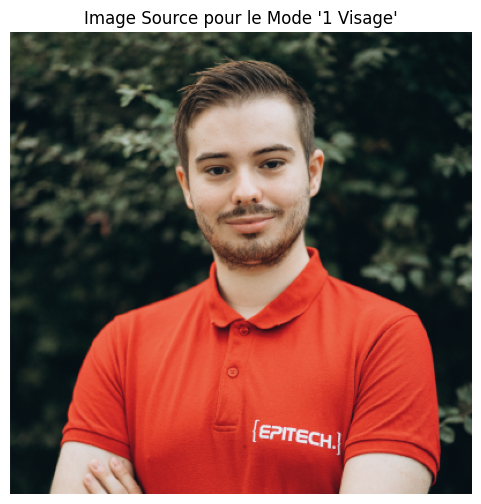

In [5]:
# Chemin vers l'image source (pour le mode 1 visage)
# Changez ce chemin pour utiliser une autre image du dossier assets/
SOURCE_IMAGE_PATH = '../assets/Julien.png'

# Vérifier que l'image existe
if os.path.exists(SOURCE_IMAGE_PATH):
    print(f"✓ Image source trouvée: {SOURCE_IMAGE_PATH}")
    
    # Afficher l'image source
    source_img = cv2.imread(SOURCE_IMAGE_PATH)
    if source_img is not None:
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(source_img, cv2.COLOR_BGR2RGB))
        plt.title("Image Source pour le Mode '1 Visage'")
        plt.axis('off')
        plt.show()
else:
    print(f"⚠️ Image source non trouvée: {SOURCE_IMAGE_PATH}")
    print("   Le mode '1 visage' ne sera pas disponible.")
    print("   Seul le mode '2 visages' fonctionnera.")
    SOURCE_IMAGE_PATH = None

📁 Configuration:
   Vidéo d'entrée: ../assets/Indian.mp4
   Vidéo de sortie: ../assets/output_swapped.mp4
   Image source: ../assets/Julien.png

✓ Vidéo d'entrée trouvée!

   📊 Informations vidéo:
      Résolution: 1920x1080
      FPS: 24
      Frames: 426
      Durée: 17.75s


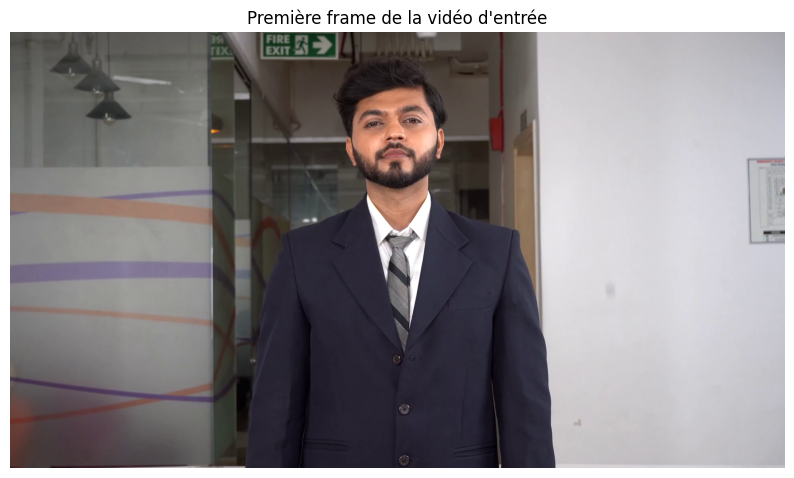


✅ Tout est prêt pour le traitement!
   Exécutez la cellule suivante pour lancer le traitement.


In [ ]:
# Configuration des chemins
INPUT_VIDEO = '../assets/2people.mp4'  # Changez ce chemin
OUTPUT_VIDEO = '../assets/output_swapped.mp4'

print("📁 Configuration:")
print(f"   Vidéo d'entrée: {INPUT_VIDEO}")
print(f"   Vidéo de sortie: {OUTPUT_VIDEO}")
print(f"   Image source: {SOURCE_IMAGE_PATH if SOURCE_IMAGE_PATH else 'Aucune (mode 2 visages uniquement)'}")

# Vérifier que la vidéo d'entrée existe
if not os.path.exists(INPUT_VIDEO):
    print(f"\n❌ ERREUR: La vidéo d'entrée n'existe pas!")
    print(f"   Veuillez placer votre vidéo à: {INPUT_VIDEO}")
    print(f"   Ou changez la variable INPUT_VIDEO ci-dessus.")
else:
    print(f"\n✓ Vidéo d'entrée trouvée!")
    
    # Afficher des infos sur la vidéo
    cap = cv2.VideoCapture(INPUT_VIDEO)
    if cap.isOpened():
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        duration = frame_count / fps if fps > 0 else 0
        
        print(f"\n   📊 Informations vidéo:")
        print(f"      Résolution: {width}x{height}")
        print(f"      FPS: {fps}")
        print(f"      Frames: {frame_count}")
        print(f"      Durée: {duration:.2f}s")
        
        # Capturer et afficher une frame
        ret, frame = cap.read()
        if ret:
            plt.figure(figsize=(10, 6))
            plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            plt.title("Première frame de la vidéo d'entrée")
            plt.axis('off')
            plt.show()
        
        cap.release()
        
        print("\n✅ Tout est prêt pour le traitement!")
        print("   Exécutez la cellule suivante pour lancer le traitement.")
    else:
        print(f"\n❌ Impossible d'ouvrir la vidéo!")

loading data from : lbfmodel.yaml
✓ Détecteur de landmarks chargé
✓ VideoFaceSwapper initialisé!
📁 Chargement de l'image source: ../assets/Julien.png
✓ Image source chargée avec 68 landmarks
🎬 DÉMARRAGE DU TRAITEMENT VIDÉO

📊 Informations vidéo:
   Résolution: 1920x1080
   FPS: 24
   Total frames: 426
   Durée: 17.75 secondes

⚙️ Traitement en cours...
   Mode: 1 visage → source | 2 visages → swap mutuel
✓ Détecteur de landmarks chargé
✓ VideoFaceSwapper initialisé!
📁 Chargement de l'image source: ../assets/Julien.png
✓ Image source chargée avec 68 landmarks
🎬 DÉMARRAGE DU TRAITEMENT VIDÉO

📊 Informations vidéo:
   Résolution: 1920x1080
   FPS: 24
   Total frames: 426
   Durée: 17.75 secondes

⚙️ Traitement en cours...
   Mode: 1 visage → source | 2 visages → swap mutuel


Traitement:   0%|          | 0/426 [00:00<?, ?frame/s]


✅ TRAITEMENT TERMINÉ

📈 Statistiques:
   Frames traitées: 426
   Frames avec 0 visage: 1 (0.2%)
   Frames avec 1 visage: 423 (99.3%)
   Frames avec 2 visages: 2 (0.5%)
   Frames avec 3+ visages: 0 (0.0%)

   Swaps réussis: 425
   Swaps échoués: 0

⏱️ Temps de traitement: 57.75s (7.38 FPS)

💾 Vidéo sauvegardée: ../assets/output_swapped.mp4

🖼️ Prévisualisation de 6 frames:


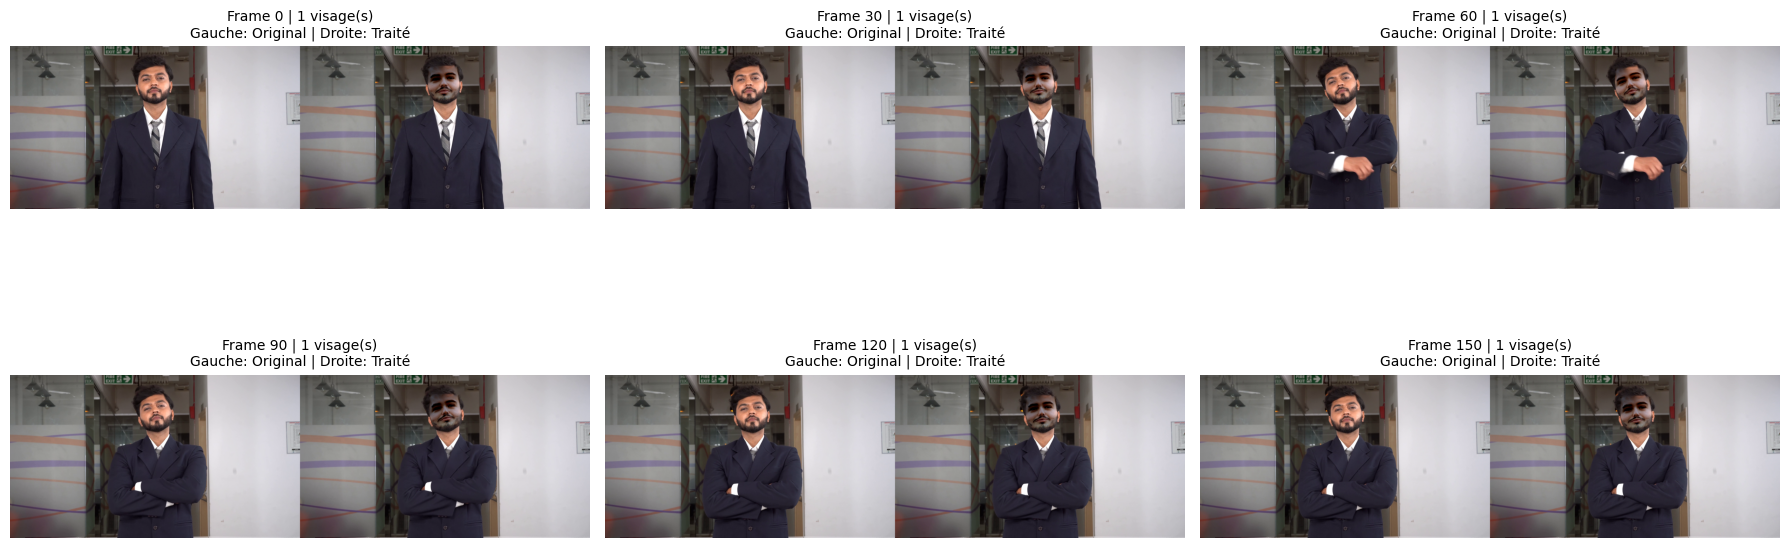


🎉 TRAITEMENT RÉUSSI!

📹 Vidéo traitée disponible à: ../assets/output_swapped.mp4

Vous pouvez maintenant:
  1. Télécharger la vidéo de sortie
  2. La lire avec un lecteur vidéo
  3. Visualiser les previews ci-dessus


In [11]:
# Initialiser le processeur avec l'image source
processor = MP4FaceSwapProcessor(source_image_path=SOURCE_IMAGE_PATH)

# Lancer le traitement
success = processor.process_video(
    input_path=INPUT_VIDEO,
    output_path=OUTPUT_VIDEO,
    show_preview=True,        # Afficher des frames de prévisualisation
    preview_interval=30        # Prévisualiser toutes les 30 frames
)

if success:
    print("\n" + "="*60)
    print("🎉 TRAITEMENT RÉUSSI!")
    print("="*60)
    print(f"\n📹 Vidéo traitée disponible à: {OUTPUT_VIDEO}")
    print("\nVous pouvez maintenant:")
    print("  1. Télécharger la vidéo de sortie")
    print("  2. La lire avec un lecteur vidéo")
    print("  3. Visualiser les previews ci-dessus")
else:
    print("\n❌ Le traitement a échoué. Vérifiez les messages d'erreur ci-dessus.")

In [12]:
# Afficher la vidéo de sortie (si disponible)
if os.path.exists(OUTPUT_VIDEO):
    print(f"📹 Lecture de la vidéo: {OUTPUT_VIDEO}")
    print("\nSi la vidéo ne s'affiche pas ci-dessous, vous pouvez:")
    print(f"  - Ouvrir directement: {OUTPUT_VIDEO}")
    print("  - Utiliser un lecteur vidéo externe (VLC, etc.)")
    
    try:
        # Essayer d'afficher avec IPython Video
        display(Video(OUTPUT_VIDEO, embed=True, width=800))
    except Exception as e:
        print(f"\n⚠️ Impossible d'afficher la vidéo dans le notebook: {e}")
        print(f"   Veuillez ouvrir manuellement: {OUTPUT_VIDEO}")
else:
    print("❌ Vidéo de sortie non trouvée. Exécutez d'abord le traitement.")

📹 Lecture de la vidéo: ../assets/output_swapped.mp4

Si la vidéo ne s'affiche pas ci-dessous, vous pouvez:
  - Ouvrir directement: ../assets/output_swapped.mp4
  - Utiliser un lecteur vidéo externe (VLC, etc.)


In [13]:
def create_side_by_side_comparison(input_video, output_video, comparison_video):
    """
    Créer une vidéo de comparaison avec original et traité côte à côte.
    """
    print("🎬 Création de la vidéo de comparaison...")
    
    # Ouvrir les deux vidéos
    cap_input = cv2.VideoCapture(input_video)
    cap_output = cv2.VideoCapture(output_video)
    
    if not cap_input.isOpened() or not cap_output.isOpened():
        print("❌ Impossible d'ouvrir les vidéos pour la comparaison")
        return False
    
    # Propriétés
    fps = int(cap_input.get(cv2.CAP_PROP_FPS))
    width = int(cap_input.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap_input.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap_input.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Writer pour la comparaison (largeur doublée)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(comparison_video, fourcc, fps, (width * 2, height))
    
    print(f"   Résolution de sortie: {width * 2}x{height}")
    print(f"   Traitement de {total_frames} frames...")
    
    frame_count = 0
    with tqdm(total=total_frames, desc="Comparaison", unit="frame") as pbar:
        while True:
            ret1, frame_input = cap_input.read()
            ret2, frame_output = cap_output.read()
            
            if not ret1 or not ret2:
                break
            
            # Ajouter des labels
            font = cv2.FONT_HERSHEY_SIMPLEX
            cv2.putText(frame_input, 'ORIGINAL', (10, 30), font, 1, (0, 255, 0), 2)
            cv2.putText(frame_output, 'FACE SWAPPED', (10, 30), font, 1, (0, 255, 0), 2)
            
            # Combiner côte à côte
            combined = np.hstack([frame_input, frame_output])
            out.write(combined)
            
            frame_count += 1
            pbar.update(1)
    
    cap_input.release()
    cap_output.release()
    out.release()
    
    print(f"✓ Vidéo de comparaison créée: {comparison_video}")
    return True

# Créer la comparaison (décommenter pour exécuter)
# COMPARISON_VIDEO = '../assets/comparison_side_by_side.mp4'
# if os.path.exists(INPUT_VIDEO) and os.path.exists(OUTPUT_VIDEO):
#     create_side_by_side_comparison(INPUT_VIDEO, OUTPUT_VIDEO, COMPARISON_VIDEO)
# else:
#     print("⚠️ Vidéos d'entrée ou de sortie manquantes")

print("💡 Décommentez le code ci-dessus pour créer une vidéo de comparaison côte à côte")

💡 Décommentez le code ci-dessus pour créer une vidéo de comparaison côte à côte


## 9. 📊 Résumé et Documentation

### 🎯 Logique Implémentée

Le système analyse **automatiquement** chaque frame de la vidéo et applique la logique suivante :

#### Mode 1 : Un Seul Visage Détecté
- ✅ **Swap avec l'image source** (`Julien.png` par défaut)
- Le visage détecté est remplacé par le visage de l'image source
- **Use case** : Anonymisation, remplacement d'identité, effets spéciaux

#### Mode 2 : Deux Visages Détectés
- ✅ **Swap mutuel entre les deux visages**
- Le visage A prend la place du visage B
- Le visage B prend la place du visage A
- **Use case** : Échange de visages, effets comiques, démonstrations

#### Mode 3 : Aucun ou 3+ Visages
- ⏭️ **Frame originale** (pas de traitement)
- Évite les erreurs et les résultats imprévisibles
- **Use case** : Scènes de foule, transitions, plans d'ensemble

---

### ✨ Fonctionnalités Techniques

1. **Détection Robuste**
   - Haar Cascade pour la détection rapide
   - 68 points de landmarks faciaux (LBF model)
   - Fallback avec estimation si landmarks échouent

2. **Face Swapping Avancé**
   - ✅ **Inclusion du front** (5 points supplémentaires)
   - ✅ **Préservation de la bouche ouverte** (intérieur conservé)
   - Triangulation de Delaunay pour mapping précis
   - Seamless cloning pour blending naturel

3. **Traitement Vidéo Optimisé**
   - Barre de progression avec `tqdm`
   - Statistiques en temps réel (nombre de visages par frame)
   - Prévisualisation de frames échantillonnées
   - Conservation de l'audio (avec post-traitement externe si nécessaire)

4. **Interface Complète**
   - Configuration facile des chemins
   - Visualisation de l'image source
   - Preview de la vidéo d'entrée
   - Statistiques détaillées après traitement
   - Comparaison côte à côte (optionnel)

---

### 🔧 Paramètres Configurables

```python
# Dans le code :
SOURCE_IMAGE_PATH = '../assets/Julien.png'  # Image pour mode 1 visage
INPUT_VIDEO = '../assets/input_video.mp4'   # Vidéo à traiter
OUTPUT_VIDEO = '../assets/output_swapped.mp4' # Vidéo de sortie

# Dans process_video() :
show_preview = True          # Afficher des frames de preview
preview_interval = 30        # Une preview toutes les N frames
```

---

### 📈 Statistiques Disponibles

Après le traitement, vous obtenez :
- **Total de frames** traitées
- **Distribution** des frames par nombre de visages (0, 1, 2, 3+)
- **Taux de succès** des swaps
- **Temps de traitement** et FPS moyen
- **Previews visuelles** de frames échantillonnées

---

### 🚀 Utilisation Rapide

```python
# 1. Charger l'image source
processor = MP4FaceSwapProcessor('../assets/Julien.png')

# 2. Traiter la vidéo
processor.process_video(
    input_path='../assets/input.mp4',
    output_path='../assets/output.mp4'
)

# 3. Visualiser le résultat
# (voir section 7 du notebook)
```

---

### 💡 Conseils d'Utilisation

1. **Qualité de la vidéo source**
   - Privilégiez des vidéos avec visages bien éclairés
   - Évitez les angles extrêmes (profil, tête baissée)
   - Résolution recommandée : 720p ou plus

2. **Image source**
   - Utilisez une photo frontale claire
   - Visage centré et bien éclairé
   - Format JPG ou PNG supporté

3. **Performance**
   - Le traitement prend ~1-3 FPS selon la machine
   - Une vidéo de 30 secondes (900 frames) prend ~5-15 minutes
   - Réduisez la résolution pour accélérer le traitement

4. **Débogage**
   - Vérifiez les previews pour valider le résultat
   - Consultez les statistiques pour comprendre la distribution
   - Si beaucoup d'échecs, vérifiez l'éclairage et les angles

---

### 🎓 Contexte Projet Epitech

Ce notebook a été développé dans le cadre du projet **G-AIA-910-PAR-9-1-computervision-4** à Epitech.

**Objectifs pédagogiques** :
- Maîtrise d'OpenCV pour la vision par ordinateur
- Implémentation d'algorithmes de face swapping
- Traitement de flux vidéo en Python
- Gestion de projets de computer vision complexes

**Technologies utilisées** :
- Python 3.13
- OpenCV (opencv-python, opencv-contrib-python)
- NumPy, SciPy, Matplotlib
- Jupyter Notebook pour documentation interactive

## 8. Comparaison Côte à Côte (Optionnel)

Créez une vidéo de comparaison avec l'original et le traité côte à côte.

## 7. Visualisation de la Vidéo de Sortie

Essayez de lire la vidéo traitée directement dans le notebook (si supporté par votre navigateur).

### 🚀 Lancer le Traitement

Exécutez cette cellule pour traiter la vidéo avec la logique intelligente de face swapping !

## 6. Traitement de la Vidéo

Spécifiez les chemins d'entrée/sortie et lancez le traitement !

## 5. Configuration - Charger l'Image Source

Spécifiez l'image source du dossier `assets/` qui sera utilisée pour le mode "1 visage".

## 4. Processeur de Vidéo MP4 avec Logique Intelligente

Cette classe gère le traitement complet de la vidéo avec la logique :
- **1 visage** → Swap avec image source
- **2 visages** → Swap entre eux

## 3. Classes de Base - Face Swapping

Les mêmes classes que dans `face_anonymization.ipynb` mais optimisées pour le traitement vidéo.

## 2. Téléchargement du Modèle de Landmarks

Téléchargement du modèle LBF pour la détection des 68 points faciaux.

In [ ]:
# Install required packages
!pip install opencv-python opencv-contrib-python
!pip install numpy matplotlib scipy
!pip install tqdm  # For progress bars

print("✓ Packages installés!")

## 1. Setup et Imports

Installation des packages nécessaires et imports.